In [1]:
# 09_R : 텍스트 분석

In [2]:
# 예측 분석 모델링 실무 기법
# 소스(원저자) - http://www.ftpress.com/promotions/modeling-techniques-in-predictive-analytics-139480
# 소스(역자) - http://blog.naver.com/skk1991/220238139920

In [3]:
# Text Analysis of Movie Tag Lines

options(warn=-1)

In [61]:
library(tm)  # text mining and document management
library(stringr)  # character manipulation with regular expressions
library(grid)  # grid graphics utilities
library(ggplot2)  # graphics
library(latticeExtra)  # package used for text horizon plot
library(wordcloud)  # provides utility for plotting non-overlapping text
library(cluster)  # cluster analysis
library(proxy)

In [5]:
# R 기본 콘솔이나 RStudio 환경에서는 이렇게 하면 그래프 함수를 쓸 수 있다.
# 하지만 현재 쥬피터 환경에서는 안된다. 
# 그러므로 이 쥬피터의 맨 밑 셀에 있는 그래프 함수를 실행해서
# 전역 메모리에 함수를 얹어놓고
# 그 뒤에 코드를 실행해나가면 된다.
load("09_data/text/mtpa_split_plotting_utilities.Rdata")

In [6]:
# standardization needed for text measures
standardize <- function(x) {(x - mean(x)) / sd(x)}

In [7]:
# convert to bytecodes to avoid "invalid multibyte string" messages
bytecode.convert <- function(x) {iconv(enc2utf8(x), sub = "byte")}

In [8]:
# NLINES <- 21  # for development and test runs
# input.data.file.name <- "taglines_list_sample.txt"
#  scan("taglines_list_sample.txt", what = "character")  # development runs
# nlines_to_read <- 21  # for development and test runs

# there are 345317 records in the full taglines data file
# the number of lines in the input data file
# or maximum number of lines to read
NLINES <- 345317   
input.data.file.name <- "09_data/text/taglines_copy_data.txt"  # production runs
# read the data in blocks of nlines_to_read at a time
nlines_to_read <- 10000  # size of block of lines to read

In [9]:
# debug print was used during the code development process
debub.print.mode <- FALSE
debug.print <- function(title,date,tagline,status) {
  cat("\n title =",title,"  date = ", date," tagline",
    tagline, " status = ",status,"\n")
  }

In [10]:
# this user-defined function shows how R can be used to parse text input
tagline.parser <- function(input.list) {
# where we start depends upon the status on entry
# tagline parser can only be in one status at a time
# begin
# indicator
# title (actually a title and date status)
# moretitle (another title and data status, but following a previous title)
# tagline
# comment

# data are not clean... if you get a new movie indicator "#" start a new movie
# we may lose a few movies this way... but that is better than editing a file
# with about 40 thousand movies..

# at this time all valid dates should look be six characters long
# four numbers surrounded by parentheses 
# lets use The Birth of a Nation (1915) as the earliest possible valid date
# and the current year as the latest possible valid date 
# obtained by as.numeric(format(Sys.time(), "%Y"))
valid.years <- 1915:as.numeric(format(Sys.time(), "%Y"))
valid.years.strings.four <- paste("(",as.character(valid.years),sep="")

   text <- input.list[[1]]
   status <- input.list[[2]]
   title <- input.list[[3]]
   date <- input.list[[4]]
   tagline <- input.list[[5]]
   
   nitems <- length(text)
   ncount <- 1  # initialize on entry
   tagline_data.store <- NULL
   
   while(ncount < nitems) {   
# debug printing was used in the development and testing of parsing logic   
     if (debub.print.mode) debug.print(title,date,tagline,status) 
     if (status == "indicator" | status == "begin") {
       if (ncount <= nitems) {
         ncount <- ncount + 1
         status <- "initialtitle"
         title <- " "  # blank title to start
         date <- " "   # blank date to start
         tagline <- " "  # blank tagline to start
         }
       }
       
     if (status == "initialtitle") {
       if (ncount <= nitems) {
         title <- text[ncount]
         ncount <- ncount + 1
         if (ncount <= nitems) {
           test_date <- text[ncount]
           if (substring(test_date,1,5) %in% valid.years.strings.four) {
             date <- test_date
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (!(substring(test_date,1,5) %in% valid.years.strings.four)) {     
             if (test_date == "#") {
                 status <- "indicator"
                 }           
             if (test_date != "#") {
                 title <- paste(title, test_date)  
                 ncount <- ncount + 1 
                 status <- "moretitle"
                 }               
             } 
           }  
         }
       }
                                        
     if (status == "moretitle") {
       if (ncount <= nitems) {
         ncount <- ncount + 1
         if (ncount <= nitems) {
           test_date <- text[ncount]
           if (substring(test_date,1,5) %in% valid.years.strings.four) {
             date <- test_date
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (!(substring(test_date,1,5) %in% valid.years.strings.four)) {     
             if (test_date == "#") {
                 status <- "indicator"
                 }           
             if (test_date != "#") {
                 title <- paste(title, test_date)  
                 ncount <- ncount + 1  
                 }               
             } 
           }  
         }
       }                    
                                       
       if (status == "tagline") {
         if (ncount <= nitems) {
           new_text <- text[ncount]
           if (new_text == "#") {
             tagline_data.store <- rbind(tagline_data.store,
                data.frame(title, date, tagline, stringsAsFactors = FALSE))
                status <- "indicator"
             }           
           if (new_text != "#") {
             if (substring(new_text,1,1) == "{") {
               ncount <- ncount + 1
               status <- "comment"
               }
             if (substring(new_text,1,1) != "{") {
               tagline <- paste(tagline, new_text)
               ncount <- ncount + 1
               }
             }             
           }          
         }
  
       if (status == "comment") {
         if (ncount <= nitems) {
           new_text <- text[ncount]         
           if (substring(new_text,nchar(new_text),nchar(new_text)) == "}") {
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (substring(new_text,nchar(new_text),nchar(new_text)) != "}") {
             ncount <- ncount + 1
             }
           }
         }  
  } # end of primary while-loop
list(tagline_data.store, status, title, date, tagline)  # return list
}  # end of function

In [11]:
cat("\n\n","NUMBER OF LINES READ: ")



 NUMBER OF LINES READ: 

In [12]:
skip <- 0  # initialize the number of lines to skip
nlines_read_so_far <- 0  # intitialze number of lines read so far

In [13]:
status <- "begin"  # initial status
title <- " "  # blank title to start
date <- " "   # blank date to start
tagline <- " "  # blank tagline to start

In [14]:
data.store <- NULL  # initialize the data frame for storing text data

In [15]:
while(nlines_read_so_far < NLINES)  {

if ((NLINES - nlines_read_so_far) < nlines_to_read) 
  nlines_to_read <- (NLINES - nlines_read_so_far)
  
text <- scan(file = input.data.file.name, what = "character",
    skip = nlines_read_so_far, nlines = nlines_to_read)
 
# convert individual text items to bytecodes 
# to avoid to avoid "invalid multibyte string" error messages going forward
text <- bytecode.convert(text)

input.list <- list(text, status, title, date, tagline)  
 
# parse this block of text with the tagline parser function 
output.list <- tagline.parser(input.list) 
  
  new_data_for_store <- output.list[[1]]
  status <- output.list[[2]]
  title <- output.list[[3]]
  date <- output.list[[4]]
  tagline <- output.list[[5]]
      
  data.store <- rbind(data.store, new_data_for_store)
  
  nlines_read_so_far <- nlines_read_so_far + nlines_to_read
  
  cat(" ","nlines_read_so_far:",nlines_read_so_far)
  }

  nlines_read_so_far: 10000  nlines_read_so_far: 20000  nlines_read_so_far: 30000  nlines_read_so_far: 40000  nlines_read_so_far: 50000  nlines_read_so_far: 60000  nlines_read_so_far: 70000  nlines_read_so_far: 80000  nlines_read_so_far: 90000  nlines_read_so_far: 1e+05  nlines_read_so_far: 110000  nlines_read_so_far: 120000  nlines_read_so_far: 130000  nlines_read_so_far: 140000  nlines_read_so_far: 150000  nlines_read_so_far: 160000  nlines_read_so_far: 170000  nlines_read_so_far: 180000  nlines_read_so_far: 190000  nlines_read_so_far: 2e+05  nlines_read_so_far: 210000  nlines_read_so_far: 220000  nlines_read_so_far: 230000  nlines_read_so_far: 240000  nlines_read_so_far: 250000  nlines_read_so_far: 260000  nlines_read_so_far: 270000  nlines_read_so_far: 280000  nlines_read_so_far: 290000  nlines_read_so_far: 3e+05  nlines_read_so_far: 310000  nlines_read_so_far: 320000  nlines_read_so_far: 330000  nlines_read_so_far: 340000  nlines_read_so_far: 345317

In [16]:
# if there is full movie info in output list 
# add this last movie to the end of the data.store

if ((!is.null(output.list[[3]])) & 
   (!is.null(output.list[[4]])) &
   (!is.null(output.list[[5]]))) {
       title <- output.list[[3]]
       date <- output.list[[4]]
       tagline <- output.list[[5]] 
    data.store <- rbind(data.store, 
      data.frame(title, date, tagline, stringsAsFactors = FALSE))
  }

In [17]:
# data cleaning... check the date field... 
# if it does not start with "(" or end with ")"
# strip any character other than numeric in the date field
# using regular experessions coding and the replace function from stringr
data.store$replace.date <- str_replace_all(data.store$date, "[^.(0-9)]", "")

In [18]:
# at this time all valid dates should look be six characters long
# four numbers surrounded by parentheses 
# lets use The Birth of a Nation (1915) as the earliest possible valid date
# and the current year as the latest possible valid date 
# obtained by as.numeric(format(Sys.time(), "%Y"))
valid.years <- 1915:as.numeric(format(Sys.time(), "%Y"))
valid.years.strings <- paste("(",as.character(valid.years),")",sep="")

In [19]:
# valid observations must have dates with valid.years.strings
data.store$valid <- 
  ifelse((data.store$replace.date %in% valid.years.strings),"YES","NO")

In [20]:
# use the subset of movies with valid data
valid.data.store <- subset(data.store, subset = (valid == "YES"))

In [21]:
# add date field to title field to create unique identifier for each movie
valid.data.store$movie <- paste(valid.data.store$title, valid.data.store$date)

In [22]:
# strip parenteses from replace.date and create an integer variable for year
valid.data.store$replace.date <- 
  str_replace(valid.data.store$replace.date,"[(]","")
valid.data.store$replace.date <- 
  str_replace(valid.data.store$replace.date,"[)]","")
valid.data.store$year <- as.integer(valid.data.store$replace.date)

In [23]:
# merge title and tagline text into new movie text variable for text analysis
valid.data.store$text <- 
  paste(valid.data.store$title, valid.data.store$tagline)

In [24]:
# drop replace.date and reorder variables for text analysis
# at this point we have one large data frame with text columns
movies <- valid.data.store[,c("movie","year","title","tagline","text")]

In [28]:
# plot frequency of movies by year
pdf(file = "09_data/text/fig_text_movies_by_year_histogram.pdf", width = 11, height = 8.5)
ggplot.object <- ggplot(data = movies, aes(x = year)) +
  geom_histogram(binwidth = 1, fill = "blue", colour = "black") +
    labs(x = "Year of Release", 
         y = "Number of Movies in Database") +
         coord_fixed(ratio = 1/50) 

ggplot.print.with.margins(ggplot.object.name = ggplot.object,
  left.margin.pct=10, right.margin.pct=10,
  top.margin.pct=10,bottom.margin.pct=10) 
dev.off()  

pdf 
  2 

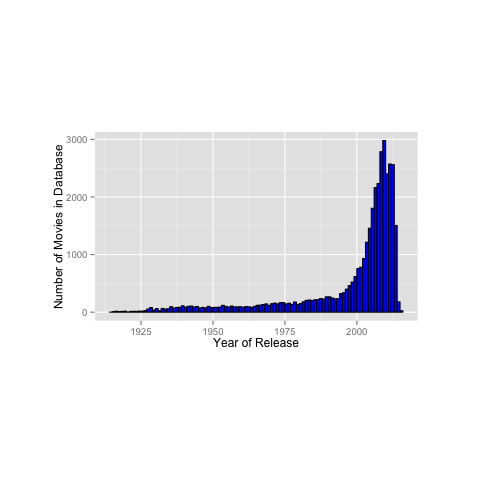

In [29]:
# pdf로 안만들고 바로 보기
ggplot.print.with.margins(ggplot.object.name = ggplot.object,
  left.margin.pct=10, right.margin.pct=10,
  top.margin.pct=10,bottom.margin.pct=10)

In [30]:
# let us work with movies from 1974 to 2013
# creating an aggregate tagline_text collection for each year of interest
years.list <- 1974:2013
document.collection <- NULL  # initialize
for (index.for.year in seq(along=years.list)) {
 
  working.year.data.frame = 
    subset(movies, subset = (year == years.list[index.for.year]))

  tagline_text <- NULL
  for(index.for.movie in seq(along = working.year.data.frame$movie)) 
    tagline_text <- 
      paste(tagline_text, working.year.data.frame$tagline[index.for.movie])
   
  document <- PlainTextDocument(x = tagline_text, author = "Tom",
    description = paste("movie taglines for ",
    as.character(years.list[index.for.year]),sep = ""),
    id = paste("movies_",as.character(years.list[index.for.year]),sep=""), 
    heading = "taglines",
    origin = "IMDb", language = "en_US", 
    localmetadata = list(year = years.list[index.for.year])) 

# give each created document a unique name  
  if (years.list[index.for.year] == 1974) Y1974 <- document  
  if (years.list[index.for.year] == 1975) Y1975 <- document  
  if (years.list[index.for.year] == 1976) Y1976 <- document  
  if (years.list[index.for.year] == 1977) Y1977 <- document  
  if (years.list[index.for.year] == 1978) Y1978 <- document  
  if (years.list[index.for.year] == 1979) Y1979 <- document     
  if (years.list[index.for.year] == 1980) Y1980 <- document  
  if (years.list[index.for.year] == 1981) Y1981 <- document   
  if (years.list[index.for.year] == 1982) Y1982 <- document  
  if (years.list[index.for.year] == 1983) Y1983 <- document  
  if (years.list[index.for.year] == 1984) Y1984 <- document  
  if (years.list[index.for.year] == 1985) Y1985 <- document  
  if (years.list[index.for.year] == 1986) Y1986 <- document  
  if (years.list[index.for.year] == 1987) Y1987 <- document  
  if (years.list[index.for.year] == 1988) Y1988 <- document  
  if (years.list[index.for.year] == 1989) Y1989 <- document  
  if (years.list[index.for.year] == 1990) Y1990 <- document  
  if (years.list[index.for.year] == 1991) Y1991 <- document   
  if (years.list[index.for.year] == 1992) Y1992 <- document  
  if (years.list[index.for.year] == 1993) Y1993 <- document  
  if (years.list[index.for.year] == 1994) Y1994 <- document  
  if (years.list[index.for.year] == 1995) Y1995 <- document  
  if (years.list[index.for.year] == 1996) Y1996 <- document  
  if (years.list[index.for.year] == 1997) Y1997 <- document  
  if (years.list[index.for.year] == 1998) Y1998 <- document  
  if (years.list[index.for.year] == 1999) Y1999 <- document  
  if (years.list[index.for.year] == 2000) Y2000 <- document  
  if (years.list[index.for.year] == 2001) Y2001 <- document   
  if (years.list[index.for.year] == 2002) Y2002 <- document  
  if (years.list[index.for.year] == 2003) Y2003 <- document  
  if (years.list[index.for.year] == 2004) Y2004 <- document  
  if (years.list[index.for.year] == 2005) Y2005 <- document  
  if (years.list[index.for.year] == 2006) Y2006 <- document  
  if (years.list[index.for.year] == 2007) Y2007 <- document  
  if (years.list[index.for.year] == 2008) Y2008 <- document  
  if (years.list[index.for.year] == 2009) Y2009 <- document  
  if (years.list[index.for.year] == 2010) Y2010 <- document  
  if (years.list[index.for.year] == 2011) Y2011 <- document  
  if (years.list[index.for.year] == 2012) Y2012 <- document  
  if (years.list[index.for.year] == 2013) Y2013 <- document  
  } # end of for-loop for selected years

In [31]:
document.collection <- c(Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,
  Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,
  Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,
  Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,
  Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013)

In [32]:
# strip whitspace from the documents in the collection
# 원 저자 코드의 tm 버전과, 현재 이 노트북의 버전이 달라서 코드를 수정해 줌.
# 소스 변경 관련 자료들
# http://stackoverflow.com/questions/24771165/r-project-no-applicable-method-for-meta-applied-to-an-object-of-class-charact
# http://stackoverflow.com/questions/21790353/dictionary-is-not-supported-anymore-in-tm-package-how-to-emend-code
document.collection <- tm_map(document.collection, content_transformer(stripWhitespace))

In [33]:
# convert uppercase to lowercase in the document collection
document.collection <- tm_map(document.collection, content_transformer(tolower))

In [34]:
# remove numbers from the document collection
document.collection <- tm_map(document.collection, content_transformer(removeNumbers))

In [35]:
# remove punctuation from the document collection
document.collection <- tm_map(document.collection, content_transformer(removePunctuation))

In [36]:
# using a standard list, remove English stopwords from the document collection
document.collection <- tm_map(document.collection, 
  removeWords, stopwords("english"))

In [38]:
# there is more we could do in terms of data preparation 
# stemming... looking for contractions... pronoun possessives... 

# we take what is clearly a "bag of words" approach here
# the workhorse technique will be TermDocumentMatrix()
# for creating a terms-by-documents matrix across the document collection
initial.movies.tdm <- TermDocumentMatrix(document.collection)

In [39]:
# remove sparse terms from the matrix and report the most common terms
# looking for additional stop words and stop word contractions to drop
examine.movies.tdm <- removeSparseTerms(initial.movies.tdm, sparse = 0.25)
top.words <- Terms(examine.movies.tdm)
print(top.words)  

  [1] "action"     "adventure"  "alive"      "alone"      "always"    
  [6] "america"    "american"   "americas"   "another"    "anything"  
 [11] "away"       "back"       "bad"        "battle"     "beautiful" 
 [16] "became"     "become"     "begins"     "behind"     "best"      
 [21] "beyond"     "big"        "biggest"    "black"      "blood"     
 [26] "body"       "born"       "boy"        "boys"       "business"  
 [31] "call"       "came"       "can"        "cant"       "century"   
 [36] "challenge"  "chance"     "city"       "classic"    "come"      
 [41] "comedy"     "comes"      "coming"     "cop"        "cops"      
 [46] "crime"      "dangerous"  "dark"       "day"        "days"      
 [51] "dead"       "deadly"     "death"      "deep"       "desire"    
 [56] "destroy"    "didnt"      "die"        "different"  "director"  
 [61] "doesnt"     "dont"       "dream"      "dreams"     "earth"     
 [66] "easy"       "end"        "enemy"      "enough"     "even"      
 [71] 

In [40]:
# an analysis of this initial list of top terms shows a number of word 
# contractions which we might like to drop from further analysis, 
# recognizing them as stop words to be dropped from the document collection
more.stop.words <- c("cant","didnt","doesnt","dont","goes","isnt","hes",
  "shes","thats","theres","theyre","wont","youll","youre","youve") 
document.collection <- tm_map(document.collection, 
  removeWords, more.stop.words)

In [41]:
# create terms-by-documents matrix across the final document collection
movies.tdm <- TermDocumentMatrix(document.collection)

In [44]:
# save movie documents and document collection (corpus)
save("movies","document.collection","movies.tdm",
  file = "000_movies_data.Rdata")  

In [45]:
# remove sparse terms from the matrix and report the most common terms
examine.movies.tdm <- removeSparseTerms(movies.tdm, sparse = 0.25)
top.words <- Terms(examine.movies.tdm)
print(top.words)  # the result of this is a bag of 200 words

  [1] "action"     "adventure"  "alive"      "alone"      "always"    
  [6] "america"    "american"   "americas"   "another"    "anything"  
 [11] "away"       "back"       "bad"        "battle"     "beautiful" 
 [16] "became"     "become"     "begins"     "behind"     "best"      
 [21] "beyond"     "big"        "biggest"    "black"      "blood"     
 [26] "body"       "born"       "boy"        "boys"       "business"  
 [31] "call"       "came"       "can"        "century"    "challenge" 
 [36] "chance"     "city"       "classic"    "come"       "comedy"    
 [41] "comes"      "coming"     "cop"        "cops"       "crime"     
 [46] "dangerous"  "dark"       "day"        "days"       "dead"      
 [51] "deadly"     "death"      "deep"       "desire"     "destroy"   
 [56] "die"        "different"  "director"   "dream"      "dreams"    
 [61] "earth"      "easy"       "end"        "enemy"      "enough"    
 [66] "even"       "ever"       "every"      "everyone"   "everything"
 [71] 

In [46]:
# now comes a test... 
# does looking at taglines hold promise as a way of identifying movie trends?
# if it does, then years closest in time should be closest to one
# another in a text measurement space as reflected, say, 
# by multidimensional scaling... 
# create a dictionary of the top words from the corpus
#top.words.dictionary <- Dictionary(c(top.words))
top.words.dictionary <- c(top.words)

In [55]:
# create terms-by-documents matrix using the mtpa.Dictionary
top.words.movies.tdm <- TermDocumentMatrix(document.collection, 
  list(dictionary = top.words.dictionary))

In [64]:
# dissimilarity measures and multidimensional scaling
# with wordlayout from the wordcloud package for non-overlapping labels
pdf(file = "09_data/text/fig_text_mds_1974_2013.pdf", width = 7, height = 7)
years.dissimilarity.matrix <- 
  dist(x = top.words.movies.tdm) #, y = NULL) #method = "cosine")
years.mds.solution <- cmdscale(years.dissimilarity.matrix, k = 2, eig = TRUE)
x <- years.mds.solution$points[,1]
y <- -years.mds.solution$points[,2]  # rotated to be consistent with biplot
w <- c("1974","1975","1976","1977","1978","1979",
  "1980","1981","1982","1983","1984","1985","1986",
  "1987","1988","1989","1990","1991","1992","1993",
  "1994","1995","1996","1997","1998","1999","2000",
  "2001","2002","2003","2004","2005","2006","2007",
  "2008","2009","2010","2011","2012","2013")
plot(x,y,type="n", xlim = c(-0.075,0.075), ylim = c(-0.075,0.075),
  xlab = "First Dimension", ylab = "Second Dimension") 
lay <- wordlayout(x, y, w, xlim = c(-0.075,0.075), ylim = c(-0.075,0.075)) 
text(lay[,1]+.5*lay[,3],lay[,2]+.5*lay[,4],w)
dev.off()

ERROR: Error in x - y: 이항연산자에 수치가 아닌 인수입니다


ERROR: Error in cmdscale(years.dissimilarity.matrix, k = 2, eig = TRUE): 객체 'years.dissimilarity.matrix'를 찾을 수 없습니다


ERROR: Error in eval(expr, envir, enclos): 객체 'years.mds.solution'를 찾을 수 없습니다


ERROR: Error in eval(expr, envir, enclos): 객체 'years.mds.solution'를 찾을 수 없습니다


ERROR: Error in plot(x, y, type = "n", xlim = c(-0.075, 0.075), ylim = c(-0.075, : 객체 'x'를 찾을 수 없습니다


ERROR: Error in is.data.frame(x): 객체 'x'를 찾을 수 없습니다


ERROR: Error in text(lay[, 1] + 0.5 * lay[, 3], lay[, 2] + 0.5 * lay[, 4], w): 객체 'lay'를 찾을 수 없습니다


pdf 
  2 

In [27]:
# Split-Plotting Utilities with grid Graphics

library(grid)  # grid graphics foundation of split-plotting utilities

# functions used with ggplot2 graphics to split the plotting region
# to set margins and to plot more than one ggplot object on one page/screen
vplayout <- function(x, y) 
viewport(layout.pos.row=x, layout.pos.col=y) 

# grid graphics utility plots one plot with margins
ggplot.print.with.margins <- function(ggplot.object.name,left.margin.pct=10,
  right.margin.pct=10,top.margin.pct=10,bottom.margin.pct=10)
{ # begin function for printing ggplot objects with margins
  # margins expressed as percentages of total... use integers
 grid.newpage() 
pushViewport(viewport(layout=grid.layout(100,100)))
print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):(100 - bottom.margin.pct),
  (0 + left.margin.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins

# grid graphics utility plots two ggplot plotting objects in one column
special.top.bottom.ggplot.print.with.margins <- 
  function(ggplot.object.name,ggplot.text.tagging.object.name,
  left.margin.pct=5,right.margin.pct=5,top.margin.pct=5,
  bottom.margin.pct=5,plot.pct=80,text.tagging.pct=10) { 
# begin function for printing ggplot objects with margins 
# and text tagging at bottom of plot
# margins expressed as percentages of total... use integers
  if((top.margin.pct + bottom.margin.pct + plot.pct + text.tagging.pct) != 100) 
    stop(paste("function special.top.bottom.ggplot.print.with.margins()",
    "execution terminated:\n   top.margin.pct + bottom.margin.pct + ",
    "plot.pct + text.tagging.pct not equal to 100 percent",sep=""))  
  grid.newpage() 
  pushViewport(viewport(layout=grid.layout(100,100)))
  print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):
    (100 - (bottom.margin.pct + text.tagging.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

  print(ggplot.text.tagging.object.name, 
    vp=vplayout((0 + (top.margin.pct + plot.pct)):(100 - bottom.margin.pct),
    (0 + left.margin.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins and text tagging

# grid graphics utility plots three ggplot plotting objects in one column
three.part.ggplot.print.with.margins <- function(ggfirstplot.object.name,
ggsecondplot.object.name,
ggthirdplot.object.name,
left.margin.pct=5,right.margin.pct=5,
top.margin.pct=10,bottom.margin.pct=10,
first.plot.pct=25,second.plot.pct=25,
third.plot.pct=30) { 
# function for printing ggplot objects with margins and top and bottom plots
# margins expressed as percentages of total... use integers
if((top.margin.pct + bottom.margin.pct + first.plot.pct + 
  second.plot.pct  + third.plot.pct) != 100) 
    stop(paste("function special.top.bottom.ggplot.print.with.margins()",
         "execution terminated:\n   top.margin.pct + bottom.margin.pct",
         "+ first.plot.pct + second.plot.pct  + third.plot.pct not equal",
         "to 100 percent",sep=""))  
grid.newpage() 
pushViewport(viewport(layout=grid.layout(100,100)))

print(ggfirstplot.object.name, vp=vplayout((0 + top.margin.pct):
  (100 - (second.plot.pct  + third.plot.pct + bottom.margin.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

print(ggsecondplot.object.name, 
  vp=vplayout((0 + top.margin.pct + first.plot.pct):
  (100 - (third.plot.pct + bottom.margin.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

print(ggthirdplot.object.name, 
  vp=vplayout((0 + top.margin.pct + first.plot.pct + second.plot.pct):
  (100 - (bottom.margin.pct)),(0 + left.margin.pct):
  (100 - right.margin.pct))) 
} 

# grid graphics utility plots two ggplot plotting objects in one row
# primary plot graph at left... legend at right
special.left.right.ggplot.print.with.margins <- 
  function(ggplot.object.name, ggplot.text.legend.object.name,
  left.margin.pct=5, right.margin.pct=5, top.margin.pct=5,
  bottom.margin.pct=5, plot.pct=85, text.legend.pct=5) { 
# begin function for printing ggplot objects with margins 
# and text legend at bottom of plot
# margins expressed as percentages of total... use integers
  if((left.margin.pct + right.margin.pct + plot.pct + text.legend.pct) != 100) 
    stop(paste("function special.left.right.ggplot.print.with.margins()",
    "execution terminated:\n   left.margin.pct + right.margin.pct + ",
    "plot.pct + text.legend.pct not equal to 100 percent",sep=""))  
  grid.newpage() 
  pushViewport(viewport(layout=grid.layout(100,100)))
  print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):(100 - (bottom.margin.pct)),
  (0 + left.margin.pct + text.legend.pct):(100 - right.margin.pct))) 

  print(ggplot.text.legend.object.name, 
    vp=vplayout((0 + (top.margin.pct)):(100 - bottom.margin.pct),
    (0 + left.margin.pct + plot.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins and text legend